Leak data shape: (11532, 320)
Normal data shape: (9100, 320)


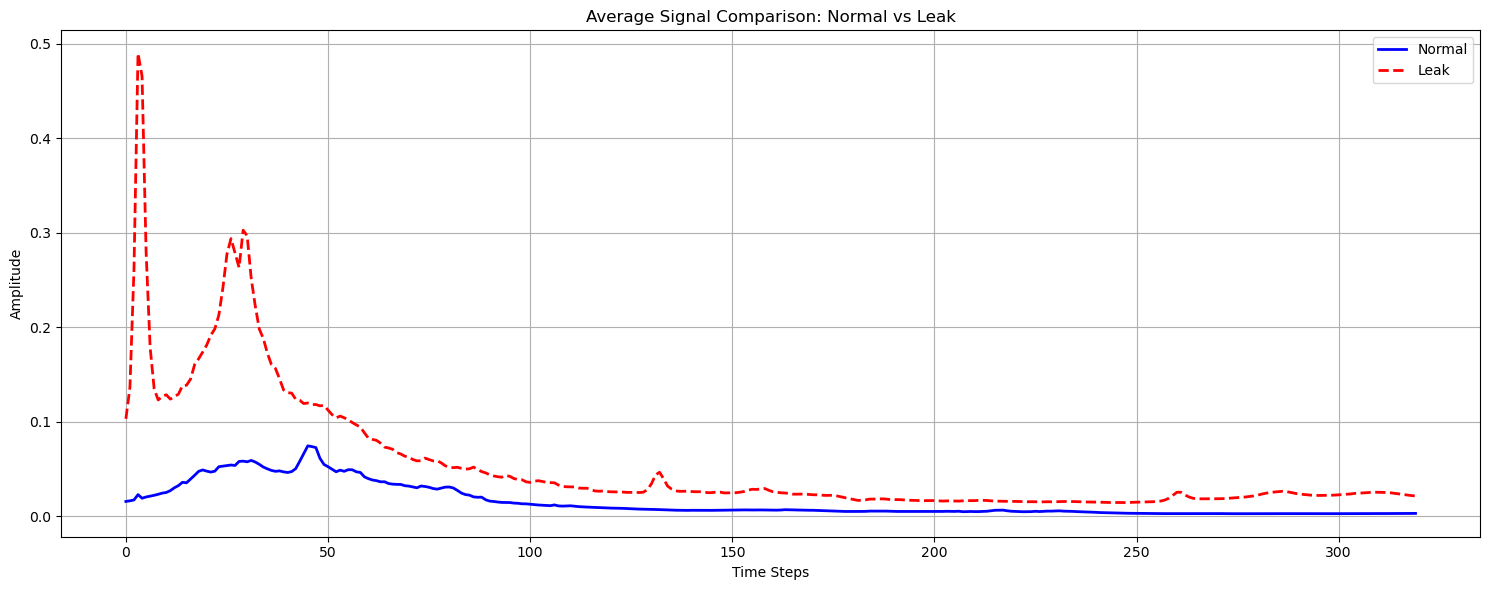

In [29]:
import os
import struct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def read_dat_data(filename):
    
    n_packet = 320
    data = np.memmap(filename, dtype=np.float32)
    return np.reshape(data, [-1, n_packet])


def read_csv_data(filename):

    try:
        csv_data = pd.read_csv(filename, encoding='cp949')
        data_list = csv_data.loc[:, ['SENSOR_DATA']].values
        data = np.empty((0, 320))
        
        for value in data_list:
            value_split = np.array([float(x) for x in value[0].split('|')])
            
            # 이상치 필터링
            if np.sum(value_split ** 2) < 1e10:
                data = np.concatenate([data, value_split[np.newaxis, :]], axis=0)
                
        return data
    except Exception as e:
        print(f"Error reading CSV file {filename}: {str(e)}")
        return np.empty((0, 320))


def load_data(data_dir, data_type='leak'):

    data_path = os.path.join(data_dir, data_type)
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Directory not found: {data_path}")
        
    data = np.empty((0, 320))
    
    for filename in os.listdir(data_path):
        file_path = os.path.join(data_path, filename)
        _, ext = os.path.splitext(filename)
        
        if ext == '.dat':
            data_tmp = read_dat_data(file_path)
        elif ext == '.csv':
            data_tmp = read_csv_data(file_path)
        else:
            continue
            
        data = np.append(data, data_tmp, axis=0)
    
    return data


def plot_average_signals(normal_data, leak_data):
 
    # 각 데이터의 평균 계산
    normal_mean = np.mean(normal_data, axis=0)
    leak_mean = np.mean(leak_data, axis=0)
    
    # 시각화
    plt.figure(figsize=(15, 6))
    time_steps = np.arange(len(normal_mean))
    
    # 정상 데이터 (파란색 실선)
    plt.plot(time_steps, normal_mean, 'b-', label='Normal', linewidth=2)
    
    # 누수 데이터 (빨간색 점선)
    plt.plot(time_steps, leak_mean, 'r--', label='Leak', linewidth=2)
    
    plt.title('Average Signal Comparison: Normal vs Leak')
    plt.xlabel('Time Steps')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':

    total_data_dir = 'C:/Users/oops1/total_data'

    leak_data = load_data(total_data_dir, data_type='leak')
    normal_data = load_data(total_data_dir, data_type='normal')
    
    print(f"Leak data shape: {leak_data.shape}")
    print(f"Normal data shape: {normal_data.shape}")
    

    plot_average_signals(normal_data, leak_data)

In [30]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from load_raw_data import load_data

def make_dataset_with_label(normal, leak):

    # label: normal(0), leak(1)
    data = np.concatenate([normal, leak], axis=0)
    label = np.ones(data.shape[0])
    label[:normal.shape[0]] = 0

    return train_test_split(data, label, train_size=0.8, stratify=label)

def make_data(data_dir):

    normal_data = load_data(data_dir, 'normal')
    leak_data = load_data(data_dir, 'leak')
    
    print(f"Normal data shape: {normal_data.shape}")
    print(f"Leak data shape: {leak_data.shape}")
    
    return make_dataset_with_label(normal_data, leak_data)

if __name__ == '__main__':
    
    data_dir = 'C:/Users/oops1/total_data'
    
    train_data, test_data, train_label, test_label = make_data(data_dir)
    print(f"Train data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")
    print(f"Train label shape: {train_label.shape}")
    print(f"Test label shape: {test_label.shape}")

Normal data shape: (9100, 320)
Leak data shape: (11532, 320)
Train data shape: (16505, 320)
Test data shape: (4127, 320)
Train label shape: (16505,)
Test label shape: (4127,)


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()  # Sigmoid
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def train_autoencoder(train_data, input_dim, encoding_dim, num_epochs=50, learning_rate=0.001):

    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    

    autoencoder = Autoencoder(input_dim, encoding_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)


    for epoch in range(num_epochs):
        autoencoder.train()
        optimizer.zero_grad()
        output = autoencoder(train_tensor)
        loss = criterion(output, train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    return autoencoder

def test_autoencoder(autoencoder, test_data):

    test_tensor = torch.tensor(test_data, dtype=torch.float32)
    
    autoencoder.eval()
    with torch.no_grad():
        reconstructed = autoencoder(test_tensor)
    

    reconstruction_error = torch.mean((reconstructed - test_tensor) ** 2, axis=1)
    return reconstruction_error.numpy()

In [37]:
if __name__ == '__main__':
    # train
    input_dim = train_data.shape[1]
    encoding_dim = 32
    trained_autoencoder = train_autoencoder(train_data, input_dim, encoding_dim)

    # test
    reconstruction_errors = test_autoencoder(trained_autoencoder, test_data)

    # 임계값 설정 : 상위 5%
    threshold = np.percentile(reconstruction_errors, 95)

    # 이상치 판별
    anomalies = reconstruction_errors > threshold
    print(f"Detected anomalies: {np.sum(anomalies)} out of {len(anomalies)}")

    # 감지된 이상치 중 label이 1인지 확인 (leak)
    leak_labels_detected = test_label[anomalies]  # 이상치 추출
    num_leaks_detected = np.sum(leak_labels_detected)  # leak(1) 선별
    print(f"Detected leaks among anomalies: {num_leaks_detected} out of {np.sum(anomalies)}")

Epoch [10/50], Loss: 0.2166
Epoch [20/50], Loss: 0.2041
Epoch [30/50], Loss: 0.1832
Epoch [40/50], Loss: 0.1555
Epoch [50/50], Loss: 0.1257
Detected anomalies: 207 out of 4127
Detected leaks among anomalies: 0.0 out of 207
